In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI')
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from utils import hungarian_loss
from fspool import FSPool
from model import FSEncoder
from dspn import *
from model import *
from MnistSet import MNISTSet
from MnistSet import get_loader

In [2]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=1, num_workers=2
        )

In [3]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=1, num_workers=2
        )

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import matplotlib.pyplot as plt
import numpy as np



def build_net():
    set_channels = 2
    set_size = 342
    hidden_dim = 256
    inner_lr = 800
    iters = 10
    latent_dim = 64
    input_encoder = None

    set_encoder = FSEncoderDSPN(set_channels, latent_dim, hidden_dim)
    set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
    net = Net(
        input_encoder=input_encoder, set_encoder=set_encoder, set_decoder=set_decoder
    )
    return net


class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder

        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

In [23]:
net = build_net()

In [24]:
net

Net(
  (set_encoder): FSEncoderDSPN(
    (conv): Sequential(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
    (pool): FSPool()
  )
  (set_decoder): DSPN(
    (encoder): FSEncoderDSPN(
      (conv): Sequential(
        (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      )
      (pool): FSPool()
    )
  )
)

In [25]:
optimizer = torch.optim.Adam(
    [p for p in net.parameters() if p.requires_grad], lr=0.01
)

In [26]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

### Usando chamfer loss

In [27]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)

In [28]:
expected.shape

torch.Size([1])

In [29]:
sample.shape
sample.dtype

torch.float32

In [30]:
mask_sample.shape
sample.dtype

torch.float32

tensor([0])


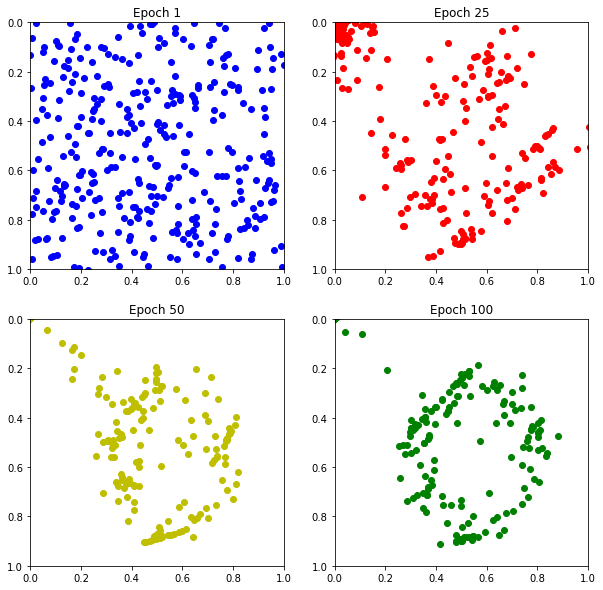

In [31]:
fig = plt.figure(figsize=(10, 10))
for i in range(500):
    input, target_set, target_mask = expected,sample,mask_sample
    if(i == 1):
        print(input)
    (progress, masks, evals, gradn), (y_enc, y_label) = net(input, target_set, target_mask)
    if i == 0:
        # =============
        # First subplot
        # =============
        # set up the axes for the first plot
        ax = fig.add_subplot(2, 2, 1)
        s = progress[10].squeeze(0).detach().numpy()
        x = s[1, :]
        y = s[0, :]
        mnsitSet = ax.scatter(x, y,color ='b')
        plt.axis([0, 1, 1, 0])
        plt.title('Epoch 1')
    if i == 14:
        #plt.title('Label: {}'.format(y_label[0].item()))
        # =============
        # Second subplot
        # =============
        # set up the axes for the first plot
        ax = fig.add_subplot(2, 2, 2)
        # plot a 3D surface like in the example mplot3d/surface3d_demo
        s = progress[4].squeeze(0).detach().numpy()
        x = s[1, :]
        y = s[0, :]
        mnsitSet = ax.scatter(x, y,color ='r')
        plt.axis([0, 1, 1, 0])
        plt.title('Epoch 25')
    if i == 49:
        # =============
        # Third subplot
        # =============
        # set up the axes for the first plot
        ax = fig.add_subplot(2, 2, 3)
        # plot a 3D surface like in the example mplot3d/surface3d_demo
        s = progress[10].squeeze(0).detach().numpy()
        x = s[1, :]
        y = s[0, :]
        mnsitSet = ax.scatter(x, y,color ='y')
        plt.axis([0, 1, 1, 0])
        plt.title('Epoch 50')
    if i == 99:
        # =============
        # Forth subplot
        # =============
        # set up the axes for the first plot
        ax = fig.add_subplot(2, 2, 4)
        # plot a 3D surface like in the example mplot3d/surface3d_demo
        s = progress[10].squeeze(0).detach().numpy()
        x = s[1, :]
        y = s[0, :]
        mnsitSet = ax.scatter(x, y,color ='g')
        plt.axis([0, 1, 1, 0])
        plt.title('Epoch 100')
    progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    set_loss = chamfer_loss(
      torch.stack(progress), target_set.unsqueeze(0)
    )
    loss = set_loss.mean()
    #print(loss.item())
    #print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
plt.show()

In [14]:
#with torch.no_grad():
(progress, masks, evals, gradn), (y_enc, y_label) = net(input,sample,mask_sample)

In [15]:
progress[0].shape
sam = progress[10].squeeze(0).detach().numpy()

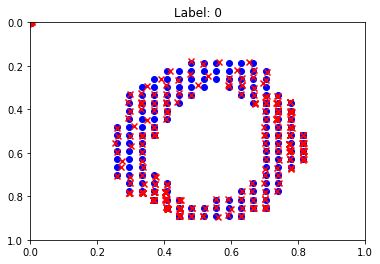

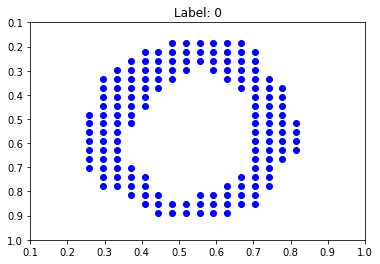

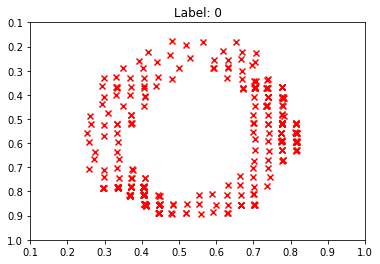

torch.Tensor

In [16]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')

x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')

pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))

pyplot.show()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)

### Usando Hungarian

In [17]:
netHungarian = build_net()
optimizer = torch.optim.Adam(
    [p for p in netHungarian.parameters() if p.requires_grad], lr=0.03
)

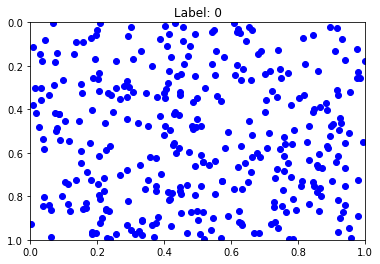

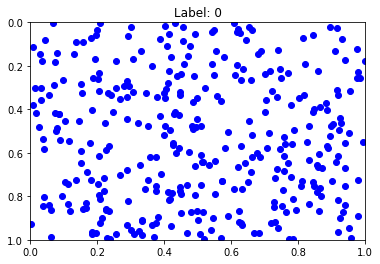

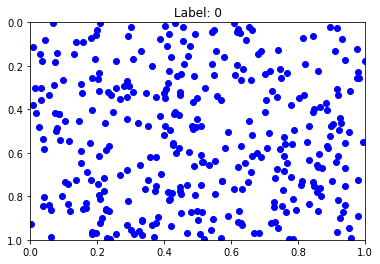

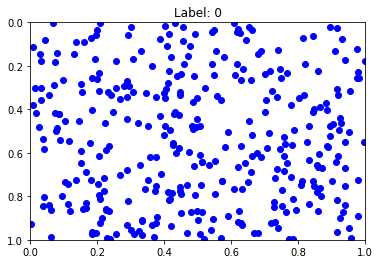

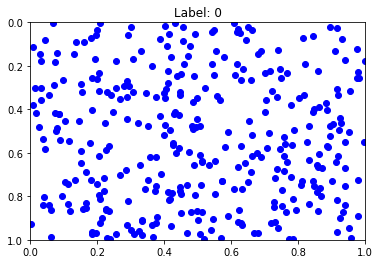

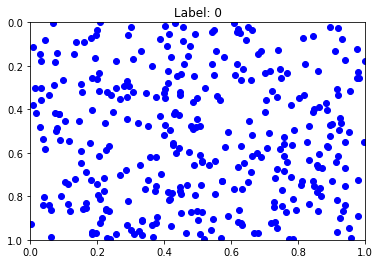

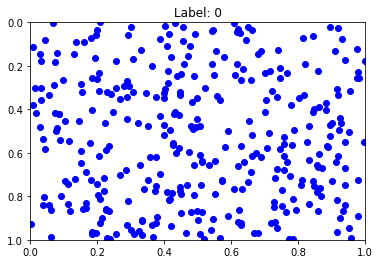

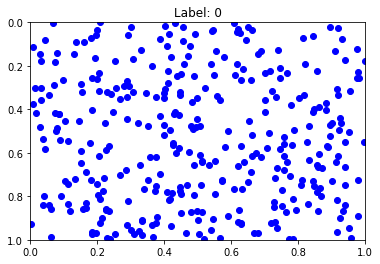

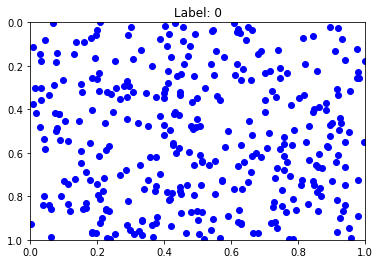

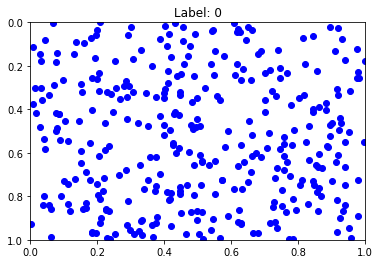

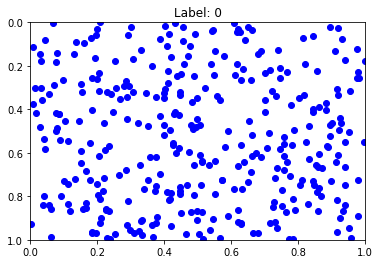

tensor(0.1637, grad_fn=<MeanBackward0>)
tensor([0])
tensor(0.0736, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.1029, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0959, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<Mean

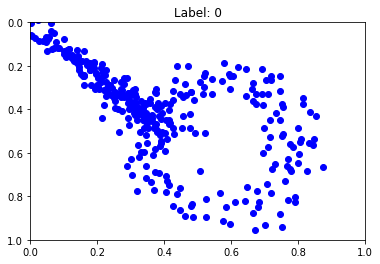

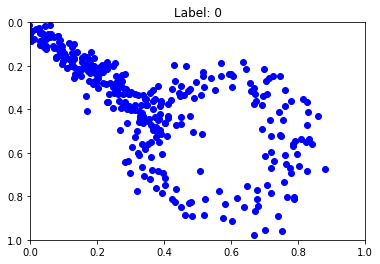

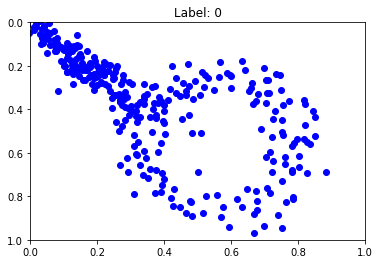

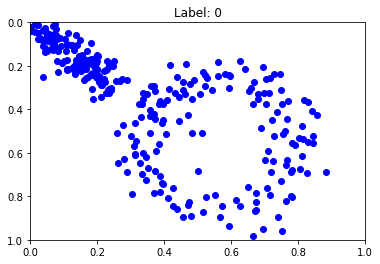

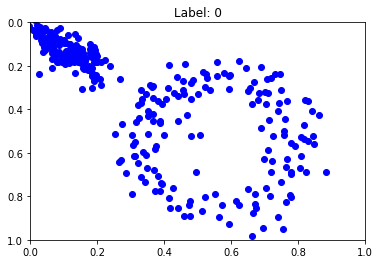

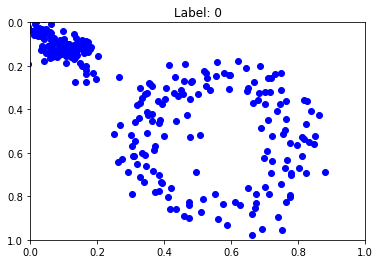

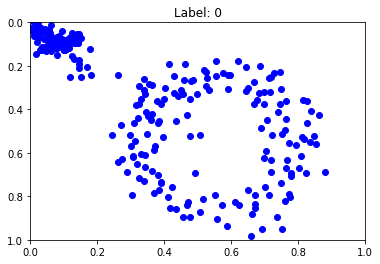

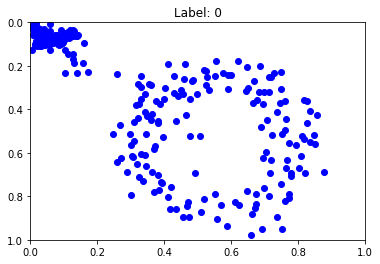

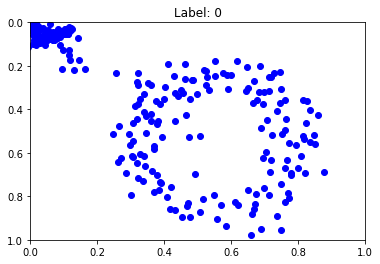

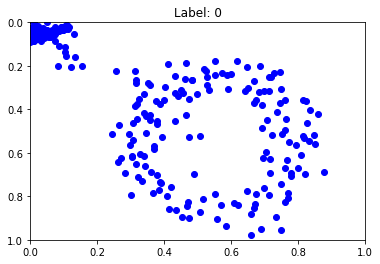

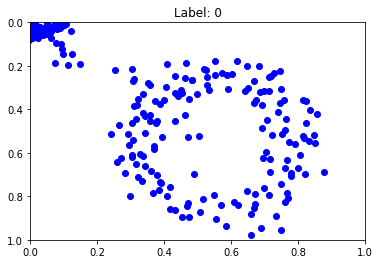

tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)


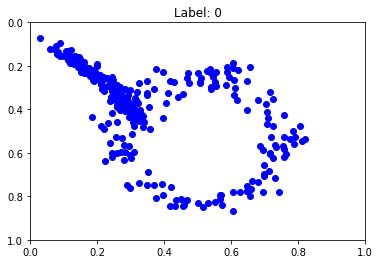

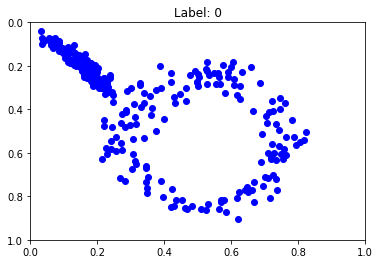

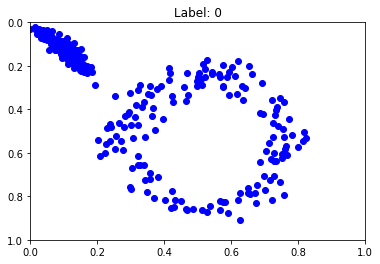

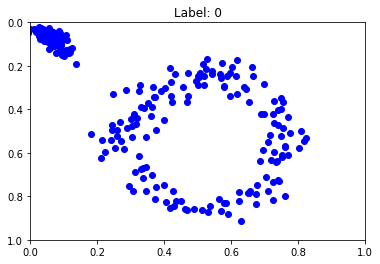

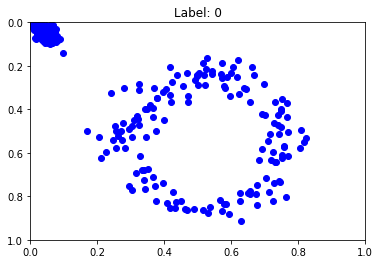

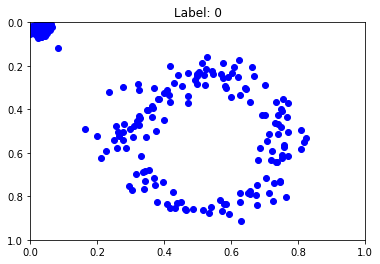

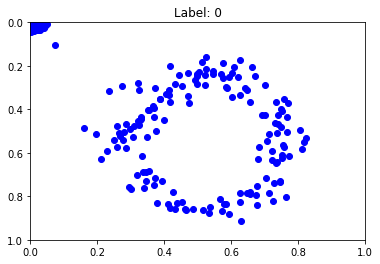

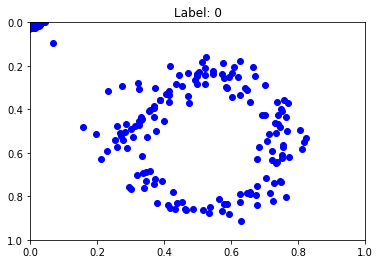

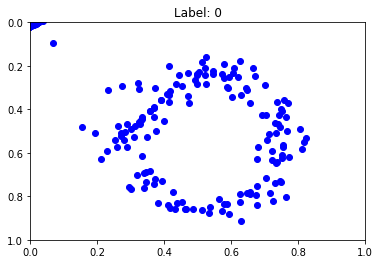

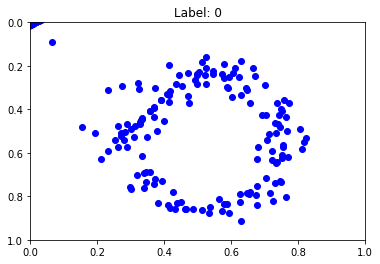

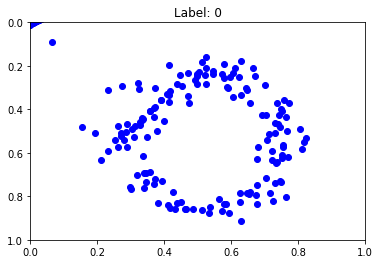

tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(9.6618e-05, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(9.1740e-05, grad_fn=<MeanBackward0>)
tensor(8.3910e-05, grad_fn=<MeanBackward0>)
tensor(8.7513e-05, grad_fn=<MeanBackward0>)
tensor(8.7572e-05, grad_fn=<MeanBackward0>)
tensor(7.9733e-05, grad_fn=<MeanBackward0>)
tensor(7.1141e-0

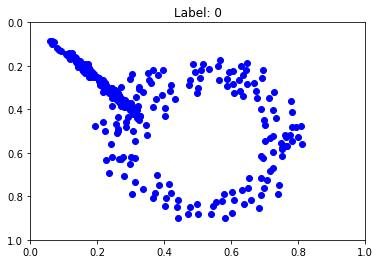

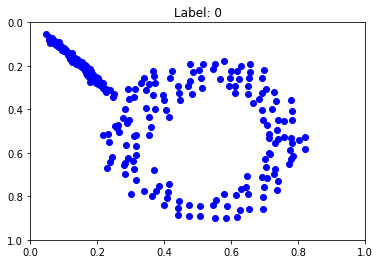

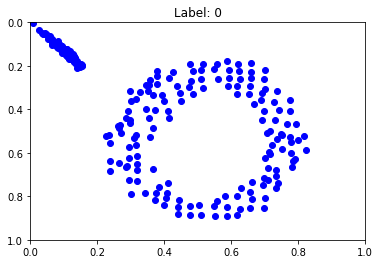

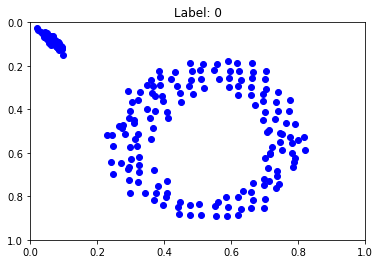

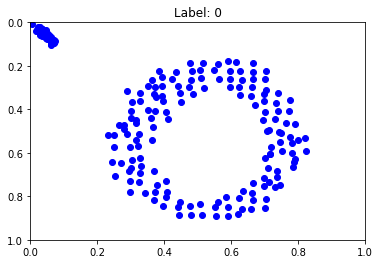

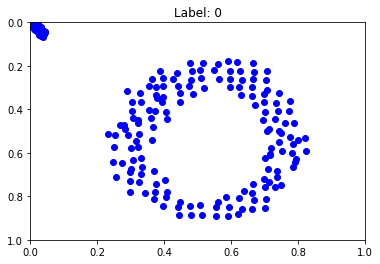

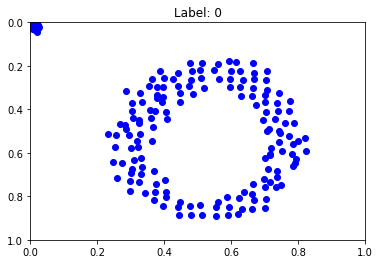

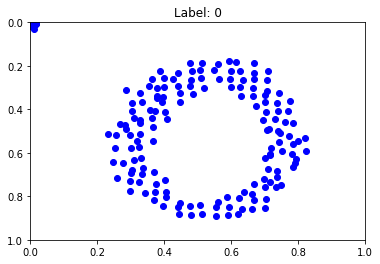

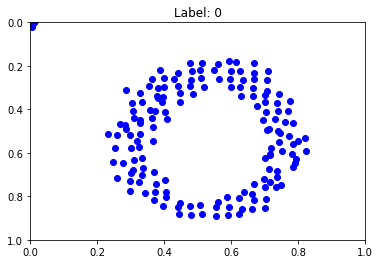

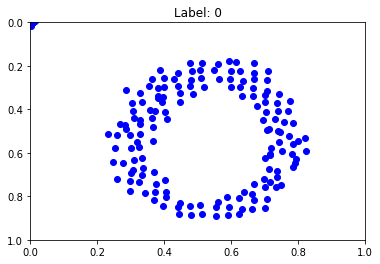

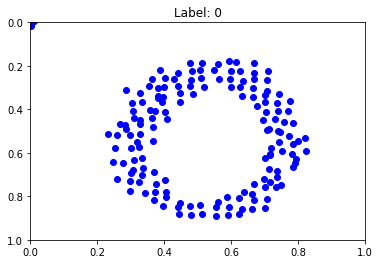

tensor(2.9845e-05, grad_fn=<MeanBackward0>)


In [18]:
for i in range(100):
    #input, target_set, target_mask = map(lambda x: x, sample)
    if(i == 1):
        print(input)
    input, target_set, target_mask = expected,sample,mask_sample
    (progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
          #print(a.shape)
            #a = a.cpu().data.numpy()
            sam = a[0].detach().numpy()
            x = sam[1, :]
            y = sam[0, :]
            pyplot.scatter(x, y,color ='b')
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    a = torch.stack(progress)
  # target set is explicitly broadcasted over dim 0
    b = target_set.repeat(a.size(0), 1, 1, 1)
  # flatten inner iteration dim and batch dim
    a = a.view(-1, a.size(2), a.size(3))
    b = b.view(-1, b.size(2), b.size(3))
    set_loss = hungarian_loss(
      progress[-1], target_set
    ).unsqueeze(0)
    loss = set_loss.mean()
    #print(set_loss)
    print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [19]:
#with torch.no_grad():
(progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input,sample,mask_sample)

In [20]:
progress[0].shape
sam = progress[10].squeeze(0).detach().numpy()

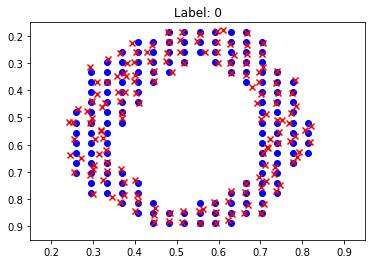

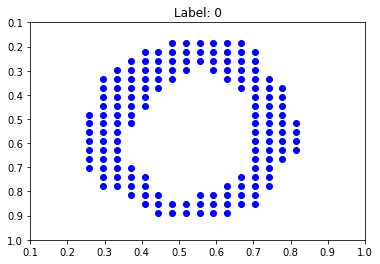

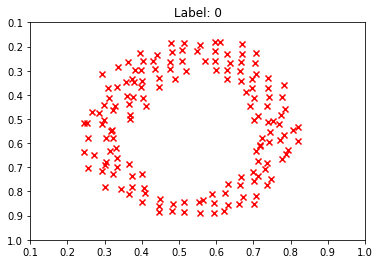

torch.Tensor

In [21]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')

x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')

pyplot.axis([0.15, 0.95, 0.95, 0.15])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))

pyplot.show()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)